In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up the paths
train_dir = '/content/drive/MyDrive/data/train/'
valid_dir = '/content/drive/MyDrive/data/valid/'

import tensorflow as tf

# Load dataset (example: CIFAR-10)
dataset = tf.data.Dataset.list_files("/content/drive/MyDrive/data/train/with_helmet_/*.jpg")

# Example of loading and checking the size of the first image in the dataset
for image_path in dataset.take(1):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # or decode_png depending on the format
    height, width, channels = image.shape
    print(f"Image size: {width}x{height} (Channels: {channels})")


import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import Sequence

# Load the CSV file with bounding box coordinates
# Assuming the CSV file contains: filename, x_min, y_min, x_max, y_max
df = pd.read_excel('/content/drive/MyDrive/data/annotation_1.csv.xlsx')

# Print the first few rows of the DataFrame for inspection
print(df.head())

# Custom Data Generator to handle bounding box cropping
class CustomImageDataGenerator(Sequence):
    def __init__(self, dataframe, image_directory, batch_size, target_size, class_mode, augmentation=None, shuffle=True):
        self.dataframe = dataframe
        self.image_directory = image_directory
        self.batch_size = batch_size
        self.target_size = target_size
        self.class_mode = class_mode
        self.augmentation = augmentation
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataframe))

        # Manually determine and set class_indices
        # Assuming 'label' column in dataframe contains class names
        self.class_indices = {label: i for i, label in enumerate(dataframe['class'].unique())}

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        batch_data = [self.dataframe.iloc[i] for i in batch_indexes]

        images = []
        labels = []

        for row in batch_data:
            # Read the image
            image_path = f"{self.image_directory}/{row['filename']}"
            image = load_img(image_path, target_size=self.target_size)
            image = img_to_array(image)

            # Get bounding box coordinates
            x_min, y_min, x_max, y_max = row['x_min'], row['y_min'], row['x_max'], row['y_max']

            # Crop the image using bounding box coordinates
            image_cropped = image[y_min:y_max, x_min:x_max]

            # Resize cropped image back to target size (since cropping changes size)
            #image_cropped = tf.image.resize(image_cropped, self.target_size)

            # Apply augmentations if specified
            if self.augmentation:
                image_cropped = self.augmentation.random_transform(image_cropped)

            images.append(image_cropped)
            labels.append(row['class'])  # Assuming 'label' is the target column

        images = np.array(images)
        labels = np.array(labels)

        return images, labels

# Initialize ImageDataGenerators for augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

valid_datagen = ImageDataGenerator(rescale=1.0 / 255)


# Create the custom data generators for training and validation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)


'''# Initialize the ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,       # Normalize pixel values to [0, 1]
    rotation_range=30,        # Rotate images randomly up to 30 degrees
    width_shift_range=0.2,    # Horizontal shifts
    height_shift_range=0.2,   # Vertical shifts
    zoom_range=0.2,           # Random zooming
    shear_range=0.2,          # Shearing transformation
    horizontal_flip=True,     # Flip images horizontally
    fill_mode='nearest',# Fill missing pixels
    brightness_range=[0.8, 1.2],  # New brightness augmentation
    validation_split=0.2
)  # Rescale images to [0, 1]
valid_datagen = ImageDataGenerator(rescale=1.0/255)

# Create the training and validation data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to a standard size (e.g., 224x224)
    batch_size=32,
    class_mode='binary'  # If you're doing binary classification (helmet vs no helmet)
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),  # Resize images to a standard size (e.g., 224x224)
    batch_size=32,
    class_mode='binary'  # Binary classification
)'''

Image size: 640x640 (Channels: 3)
                                            filename width height  \
0  a-44-_jpg.rf.417dc4fe93b685b694d98b621947415d.jpg   640    640   
1  a-44-_jpg.rf.417dc4fe93b685b694d98b621947415d.jpg   640    640   
2  BikesHelmets216_png.rf.429e69a2ce9f028114022fd...   640    640   
3  train223_jpg.rf.41e1a6e0f92a5d7ce6af44cae1fe1f...   640    640   
4  train223_jpg.rf.41e1a6e0f92a5d7ce6af44cae1fe1f...   640    640   

            class xmin ymin xmax ymax  
0  Without Helmet  229   93  304  202  
1  Without Helmet  308  123  358  211  
2  Without Helmet  287    0  344  127  
3  Without Helmet  289  185  340  243  
4  Without Helmet  349  178  399  235  
Found 4060 images belonging to 2 classes.
Found 423 images belonging to 2 classes.


"# Initialize the ImageDataGenerator\ntrain_datagen = ImageDataGenerator(\n    rescale=1.0 / 255,       # Normalize pixel values to [0, 1]\n    rotation_range=30,        # Rotate images randomly up to 30 degrees\n    width_shift_range=0.2,    # Horizontal shifts\n    height_shift_range=0.2,   # Vertical shifts\n    zoom_range=0.2,           # Random zooming\n    shear_range=0.2,          # Shearing transformation\n    horizontal_flip=True,     # Flip images horizontally\n    fill_mode='nearest',# Fill missing pixels\n    brightness_range=[0.8, 1.2],  # New brightness augmentation\n    validation_split=0.2\n)  # Rescale images to [0, 1]\nvalid_datagen = ImageDataGenerator(rescale=1.0/255)\n\n# Create the training and validation data generators\ntrain_generator = train_datagen.flow_from_directory(\n    train_dir,\n    target_size=(224, 224),  # Resize images to a standard size (e.g., 224x224)\n    batch_size=32,\n    class_mode='binary'  # If you're doing binary classification (helmet vs

In [ ]:
# Print class labels
print(train_generator.class_indices)

# Check a batch of images and labels
images, labels = train_generator[0]
print(images.shape)  # Should be (batch_size, 224, 224, 3)
print(labels)  # Labels for the batch


{'with_helmet_': 0, 'without_helmet': 1}
(32, 224, 224, 3)
[0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 1.]


In [ ]:
from tensorflow.keras import regularizers
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64,64 , 3), padding = "same"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding = "same"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding = "same"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding = "same"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding = "same"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding = "same"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),

    # Apply Elastic Net regularization to Dense layers
    Dense(10, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)),
    Dropout(0.3),  # Slightly increased dropout rate

    Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))
])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_54 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_54               │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_48 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_55 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_55               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_49 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_56 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_56               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_50 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_57 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_57               │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_51 (MaxPooling2D)      │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_58 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_58               │ (None, 4, 4, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_52 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_59 (Conv2D)                   │ (None, 2, 2, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 2, 2, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_53 (MaxPooling2D)      │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 206,997 (808.58 KB)

 Trainable params: 206,165 (805.33 KB)

 Non-trainable params: 832 (3.25 KB)

In [ ]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.0001
# Create the Adam optimizer with the learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with this optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 29, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 12, 12, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 4, 4, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 2, 2, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 2, 2, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 0, 0, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 0, 0, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 0)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 205,717 (803.58 KB)

 Trainable params: 204,885 (800.33 KB)

 Non-trainable params: 832 (3.25 KB)

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Define early_stopping and checkpoint callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)  # Stop if val_loss doesn't improve for 3 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)  # Save the best model, changed .h5 to .keras


history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 10,
    epochs=20,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // 10,
    callbacks=[early_stopping, checkpoint]  # Use the defined callbacks
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/406 ━━━━━━━━━━━━━━━━━━━━ 1:11 256ms/step - accuracy: 0.5035 - loss: 1.3064

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


406/406 ━━━━━━━━━━━━━━━━━━━━ 233s 554ms/step - accuracy: 0.5064 - loss: 1.1894 - val_accuracy: 0.5035 - val_loss: 0.8558
Epoch 2/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.5465 - loss: 0.8913 - val_accuracy: 0.5130 - val_loss: 0.9136
Epoch 3/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.5529 - loss: 0.8579 - val_accuracy: 0.5296 - val_loss: 0.8836
Epoch 4/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.5511 - loss: 0.8474 - val_accuracy: 0.5390 - val_loss: 0.8462
Epoch 5/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 32s 73ms/step - accuracy: 0.5681 - loss: 0.8406 - val_accuracy: 0.5035 - val_loss: 0.8455
Epoch 6/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 32s 74ms/step - accuracy: 0.5619 - loss: 0.8333 - val_accuracy: 0.5225 - val_loss: 0.8383
Epoch 7/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.5776 - loss: 0.8274 - val_accuracy: 0.5248 - val_loss: 0.8339
Epoch 8/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 42s 74ms/step - accuracy: 0.5734 - loss: 0.8265 - val_accur

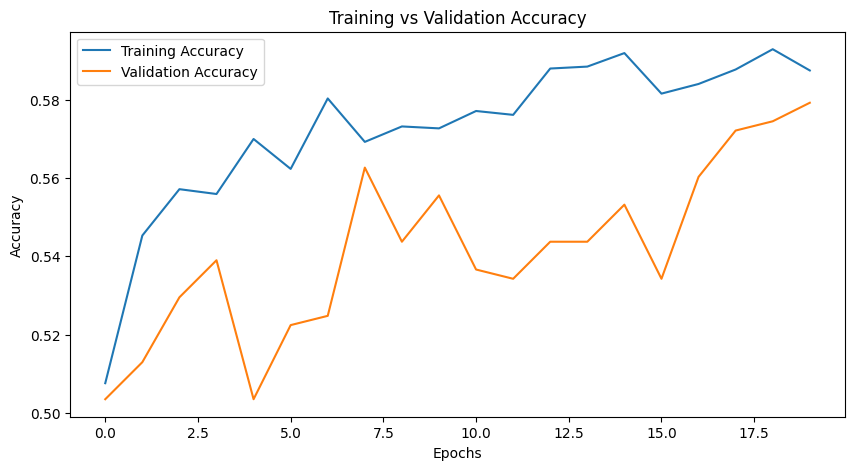

In [ ]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

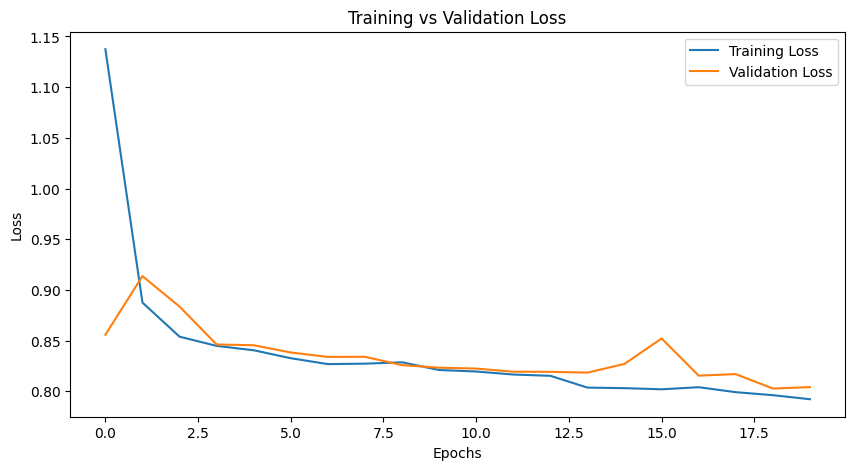

In [ ]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


In [ ]:
model.save('helmet_classifier_final.h5')

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# 1. Load the model
model = load_model('helmet_classifier_final.h5')

# 2. Compile the model (if necessary)
# Compiling the model to ensure metrics are set
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 3. Function to load and preprocess the image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Increased target size to (224, 224)
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the image
    return img_array

# 4. Function to predict and display results
def predict_image(img_path):
    img = load_and_preprocess_image(img_path)  # Preprocess the image
    predictions = model.predict(img)  # Make prediction
    class_label = 'with helmet' if predictions[0][0] > 0.5 else 'without helmet'

    # Display the image and prediction
    plt.imshow(image.load_img(img_path))
    plt.axis('off')
    plt.title('Prediction: ' + class_label)
    plt.show()

# 5. Upload and predict
uploaded = files.upload()
for fn in uploaded.keys():
    predict_image(fn)